In [1]:
import gc
from tqdm import tqdm

import nltk
from nltk.corpus import gutenberg
from nltk import word_tokenize
from nltk import trigrams, ngrams

import string
myPunctation = string.punctuation +'“'+'”'+'-'+'’'+'‘'+'—'
myPunctation = myPunctation.replace('.', '')
myPunctation

from collections import defaultdict

sentence_list = []

for Opera in tqdm(nltk.corpus.gutenberg.fileids()):
    #print(Opera)
    sentence_opera = gutenberg.sents(Opera)
    for sentence in sentence_opera:
        filteredSentence = [word for word in sentence if word not in myPunctation]
        sentence_list.append(" ".join(filteredSentence))

100%|██████████| 18/18 [00:22<00:00,  1.23s/it]


In [2]:
len(sentence_list)

98552

In [3]:
corpusText = " ".join(sentence_list[0:10000])

### Bigram

In [4]:
from numpy import array
import numpy as np
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical, plot_model
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding

# generate a sequence from the model
def generate_seq(model, tokenizer, seed_text, n_words):
	in_text, result = seed_text, seed_text
	# generate a fixed number of words
	for _ in range(n_words):
		# encode the text as integer
		encoded = tokenizer.texts_to_sequences([in_text])[0]
		encoded = array(encoded)
		# predict a word in the vocabulary
		#yhat = model.predict_classes(encoded, verbose=0)
		predict_x=model.predict(encoded)
		yhat=np.argmax(predict_x,axis=1)
		# map predicted word index to word
		out_word = ''
		for word, index in tokenizer.word_index.items():
			if index == yhat:
				out_word = word
				break
		# append to input
		in_text, result = out_word, result + ' ' + out_word
	return result

# source text
data = corpusText
# integer encode text
tokenizer = Tokenizer()
tokenizer.fit_on_texts([data])
encoded = tokenizer.texts_to_sequences([data])[0]
# determine the vocabulary size
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % vocab_size)

Vocabulary Size: 8391


In [5]:
gc.collect()

# create word -> word sequences
sequences = list()
for i in range(1, len(encoded)):
	sequence = encoded[i-1:i+1]
	sequences.append(sequence)
print('Total Sequences: %d' % len(sequences))
# split into X and y elements
sequences = array(sequences)
X, y = sequences[:,0],sequences[:,1]
# one hot encode outputs
y = to_categorical(y, num_classes=vocab_size)

Total Sequences: 217233


In [6]:
# define model
model = Sequential()
model.add(Embedding(vocab_size, 10, input_length=1))
model.add(LSTM(50))
model.add(Dense(vocab_size, activation='softmax'))
print(model.summary())
# compile network
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit network
model.fit(X, y, epochs=2, verbose=2)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1, 10)             83910     
_________________________________________________________________
lstm (LSTM)                  (None, 50)                12200     
_________________________________________________________________
dense (Dense)                (None, 8391)              427941    
Total params: 524,051
Trainable params: 524,051
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/2
6789/6789 - 121s - loss: 6.2996 - accuracy: 0.0439
Epoch 2/2
6789/6789 - 121s - loss: 5.7181 - accuracy: 0.0913


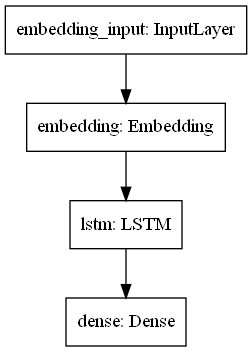

In [7]:
plot_model(model)

In [8]:
# evaluate
print(generate_seq(model, tokenizer, 'I', 10))

I am a very much of the same much of the


### Trigram

In [9]:
from numpy import array
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# generate a sequence from a language model
def generate_seq(model, tokenizer, max_length, seed_text, n_words):
	in_text = seed_text
	# generate a fixed number of words
	for _ in range(n_words):
		# encode the text as integer
		encoded = tokenizer.texts_to_sequences([in_text])[0]
		# pre-pad sequences to a fixed length
		encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')
		# predict probabilities for each word
		#yhat = model.predict_classes(encoded, verbose=0)
		predict_x=model.predict(encoded)
		yhat=np.argmax(predict_x,axis=1)
		# map predicted word index to word
		out_word = ''
		for word, index in tokenizer.word_index.items():
			if index == yhat:
				out_word = word
				break
		# append to input
		in_text += ' ' + out_word
	return in_text

In [10]:
# integer encode sequences of words
tokenizer = Tokenizer()
tokenizer.fit_on_texts([data])
encoded = tokenizer.texts_to_sequences([data])[0]
# retrieve vocabulary size
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % vocab_size)

Vocabulary Size: 8391


In [11]:
# encode 2 words -> 1 word
sequences = list()
for i in range(2, len(encoded)):
	sequence = encoded[i-2:i+1]
	sequences.append(sequence)
print('Total Sequences: %d' % len(sequences))

Total Sequences: 217232


In [12]:
# pad sequences
max_length = max([len(seq) for seq in sequences])
sequences = pad_sequences(sequences, maxlen=max_length, padding='pre')
print('Max Sequence Length: %d' % max_length)
# split into input and output elements
sequences = array(sequences)
X, y = sequences[:,:-1],sequences[:,-1]
y = to_categorical(y, num_classes=vocab_size)

Max Sequence Length: 3


In [13]:
# define model
model = Sequential()
model.add(Embedding(vocab_size, 10, input_length=max_length-1))
model.add(LSTM(50))
model.add(Dense(vocab_size, activation='softmax'))
print(model.summary())
# compile network
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit network
model.fit(X, y, epochs=2, verbose=2)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 2, 10)             83910     
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                12200     
_________________________________________________________________
dense_1 (Dense)              (None, 8391)              427941    
Total params: 524,051
Trainable params: 524,051
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/2
6789/6789 - 152s - loss: 6.3185 - accuracy: 0.0465
Epoch 2/2
6789/6789 - 117s - loss: 5.6247 - accuracy: 0.1030


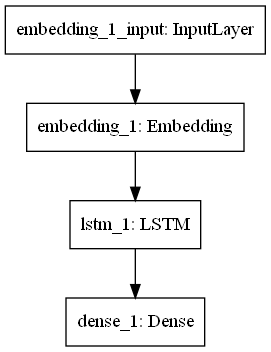

In [14]:
plot_model(model)

In [16]:
# evaluate model
print(generate_seq(model, tokenizer, max_length-1, 'I am', 9))

I am sure to be a very very very very very
